This example shows how to use viflow for fluid-structure interaction. The airfoil as the famous NACA0012, and we assume that it somehow behaves like a beam that is fixed in the front part up to .2c.
To to this, we will not rely on viiflow to solve the aerodynamic problem, but just use its computed gradient and residual to couple those with our structure problem for a joint Newton step.

This necessitates:

* a structure model
* the means to give the structure model the surface pressure based on the aerodynamic calculation
* a coupling Newton loop

This is why this notebook is rather long.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Settings
RE = 1e6
ncrit = 9.0
Mach = 0.0
alpha = 6.0

# Setup for viiflow
s = vf.setup(Re=RE,Ma=Mach,ncrit=ncrit,alpha=alpha)

# Internal iterations
s.virtual_gradients = True # You need to set this for FSI problems.
s.gradients = True # You need to set this for FSI problems.
# If iterate_wakes is False, the wake does not change when moving which may lead to better convergence.
# If True, the wake changes. Because the gradient does not take movement of nodes into account,
# this may leasd to poorer convergence.
s.iterate_wakes = True 
#s.equal_wakes = 1

# Read Airfoil Data
NACA0012 = vft.repanel(vft.read_selig("NACA0012.dat"),180)

## Structural Model
Let $s \in [0,L]$ be the variable along the length of the beam and $q$ be the load on this beam at these elements.
The simple beam fixed at the s(0) is defined by 
$$ \frac{d^2}{ds^2} EI \frac{d^2}{ds^2} y = q $$
$$ y(0) = 0, \frac{d}{ds} y(0) = 0 $$
$$ \frac{d^2}{ds^2} y(L) = 0, \frac{d^3}{ds^3} y(L) = 0 $$

To keep things sane, we will use $M = - EI \frac{d^2}{ds^2} y$ as an additional variable.

$$ - \frac{d^2}{ds^2} M = q, M(L) = 0, \frac{d}{ds} M(L) = 0 \ (I) $$
$$ - EI \frac{d^2}{ds^2} y = M (I) , y(0) = 0, \frac{d}{ds} y(0) = 0 \ (II) $$
    
Since we use the foil coordinates from the top, the actual free end is at $s=0$, while the fixed and is at the end of $s$.

The load $q$ is due to the aerodynamic pressure difference between top and bottom side. From the external velocities $u_{top}$ and $u_{bot}$ on the airfoil sides it is calculated by $q=u_{top}^2-u_{bot}^2$.
    

In [2]:
# Define Structure Model
def beam(s,q):
    # s is the variable along the length of the beam
    # q is the load on this beam at these elements
    
    EI = .5 # Random scale. Too low: So much movement that you see transient wiggling. Too high: Very little change in geometry.
    N = len(s) # Number of elements
    
    # Second order differential operator
    # d²/ds²
    D = np.zeros((N,N))
    for k in range(1,N-1):
        dm = s[k]-s[k-1]
        dp = s[k+1]-s[k]
        D[k,k-1] = 2/dm/(dm+dp)
        D[k,k] = -2/dp/(dm+dp)-2/dm/(dm+dp)
        D[k,k+1] = 2/dp/(dm+dp)
    
    # Operator (I)
    O1 = -D
    O1[0,0] = 1
    O1[-1,[0, 1]] = [-1,1]/(s[1]-s[0])
    
    # Operator (II)
    O2 = -np.multiply(EI,D)
    O2[0,N-1] = 1
    O2[-1,[N-2, N-1]] = [-1,1]/(s[N-1]-s[N-2])
    
    # Solve for displacement
    E0 = np.eye(N)
    E0[0,0] = 0
    E0[-1,-1] = 0
    M = np.linalg.solve(O1,np.matmul(E0,q))
    dMdq = np.linalg.solve(O1,E0)
    y = np.linalg.solve(O2,np.matmul(E0,M))
    dydq = np.linalg.solve(O2,np.matmul(E0,dMdq))
    
    return [y,dydq]

def af_root(p):
    # Find root of airfoil
    iroot = 0
    for k in range(1,p.foils[0].N):
        if p.foils[0].X[0,k]>p.foils[0].X[0,k-1]:
            iroot = k
            break
    return iroot

# How to calculate pressure difference on this beam based on the aerodynamics
def q_beam(SB,p,dgam):
    
    iroot = af_root(p)
    N = p.foils[0].N
    
    # interpolate velocities to beam SB
    utop = np.interp(-SB,-p.foils[0].X[0,0:iroot],np.asarray(p.gamma_viscid[0:iroot]).flatten())
    ubot = np.interp(SB,p.foils[0].X[0,iroot::],np.asarray(p.gamma_viscid[iroot:N]).flatten())
    
    # Pressure difference
    q = utop**2-ubot**2
    
    # Gradient. Only true for linear interpolation!
    dq = None
    if not dgam is None:
        dq = np.zeros((q.shape[0],dgam.shape[1]))
        
        # dq = dq_utop*dutop + dq_ubot*dubot
        #    = 2*utop*dutop + ...
        for i in range(dgam.shape[1]):
            dq[:,i]+= 2*utop*np.interp(-SB,-p.foils[0].X[0,0:iroot-1],np.asarray(dgam[0:iroot-1,i]).flatten())
            dq[:,i]+= 2*ubot*np.interp(SB,p.foils[0].X[0,iroot::],np.asarray(dgam[iroot:N,i]).flatten())
    return [q,dq]

## Aerodynamic problem
First, we solve the aerodynamic problem without the structural part. The solution is used as a starting point for the subsequent calculations.

In [3]:


# Set-up and initialize based on inviscid panel solution
[p,bl,x] = vf.init([NACA0012],s)
res = None
grad = None
#plt.plot(bl[0].bl_fl.nodes.xi,bl[0].bl_fl.nodes.HK)
#plt.plot(1+bl[0].bl_wk.nodes.xi,bl[0].bl_wk.nodes.HK)

# Solve aerodynamic problem
[x,_,_,_,_] = vf.iter(x,bl,p,s,None,None)


Iteration 12, |res| 0.000631, lam 0.500000


In [4]:
# FSI Setup

# This is our beam, the x values of the top side from TE until 0.2
ii = 0 # Index where the beam starts
for k in range(p.foils[0].N):
    if p.foils[0].X[0,k]<0.2:
        ii = k
        break

SB = p.foils[0].X[0,0:ii]
ND = len(SB)

# How do we get the complete foil displacement from xtop?
def vdfull(p,xtop):
    NXT = xtop.shape[0]
    NP = p.foils[0].N
    iroot = af_root(p)
    vd = np.zeros(p.foils[0].N)
    vd[0:NXT] = xtop
    vd[iroot::] = -np.interp(-p.foils[0].X[0,iroot::],-p.foils[0].X[0,0:iroot],vd[0:iroot])
    
    # Gradient
    dvd_xtop = np.zeros((NP,NXT))
    E = np.eye(NXT)
    dvd_xtop[0:NXT,0:NXT] = E
    for k in range(NXT):
        dvd_xtop[iroot::,k] = -np.interp(-p.foils[0].X[0,iroot::],-p.foils[0].X[0,0:NXT],E[:,k])
        
    return [vd, dvd_xtop]

## Joint Newton Iteration
The next section combines viiflow with the above structural model to solve for stationary conditions. That is, due to the pressure difference $q$ the airfoil is deformed, which changes its pressure variation and hence $q$. In the end, we need a structural displacement $y_{var}$ that is equivalent to the deformation due to the loads due to this deformation $y_q(q(y_{var}))=y_{var}$.

In [5]:
# Newton Iteration
tol = 1e-4
# Additional unknowns: The displacement on the top side
# On the bottom, we have the negative displacement at the same x coordinates
xtop = np.zeros(ii) # Initialize with 0
xj = np.r_[x,xtop] # Joined aerodynamic and structural variables
NAERO = x.shape[0]
NTOP = ii

s.itermax = 0 # Disable internal iterations. Important! 
s.silent = True

vres_s = [] # Vector of stuctural residuals 
vres_a = [] # Vector of aerodynamic residuals 

for k in range(100):
    
    
    res = None
    grad = None
    
    # Current virtual displacements
    [vd, dvd_xj] = vdfull(p,xj[NAERO::])
    
    # Solve Aerodynamics
    [xj[0:NAERO],flag,res,grad,grad_vii] = vf.iter(xj[0:NAERO],bl,p,s,res,grad,[vd])
    
    # Gradient of aerodynamic problem w.r.t. xj
    dres_xj = np.c_[grad,np.matmul(grad_vii.res_vd,dvd_xj)]
    
    # Get structural loads
    [q,dq_dxaero] = q_beam(SB,p,grad_vii.gam_x)
    [_,dq_dvd] = q_beam(SB,p,grad_vii.gam_vd)
    
    # Solve structural part
    [y,dydq] = beam(SB,q)
    
    # Gradient of structural problem w.r.t. xj
    dy_xaero = np.matmul(dydq,dq_dxaero)
    dy_xtop = np.matmul(dydq,np.matmul(dq_dvd,dvd_xj))
    
    # Interaction goal: y - xtop = 0
    # Aerodynamic goal: res = 0
    res_s = y-xj[NAERO::]
    F = np.r_[res_s,res]
    DF = np.r_[np.c_[dy_xaero,dy_xtop-np.eye(NTOP)],dres_xj]
    
    # Newton Step
    dxj = -np.linalg.solve(DF,F)
    
    # Some Newton step-size restriction
    lam = 1.0
    for k in range(NAERO-3):
        if abs(dxj[k])>0:
            lam = min(lam,.2/(abs(dxj[k])/abs(xj[k])))
    for k in range(NAERO,NAERO+NTOP):
        if abs(dxj[k])>0:
            lam = min(lam,.2/(abs(dxj[k])/max(abs(xj[k]),0.02)))
        
    xj += lam*dxj
    
    vres_s.append(np.sqrt(np.sum(res_s*res_s)))
    vres_a.append(np.sqrt(np.sum(res*res)))
    
    if np.sqrt(np.sum(F*F))<tol or np.sqrt(np.sum(dxj*dxj))<tol:
        break


    

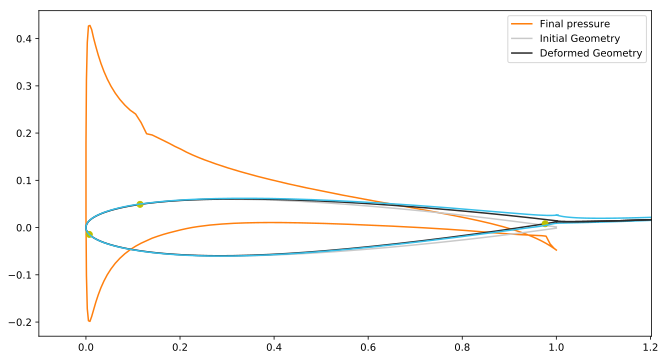

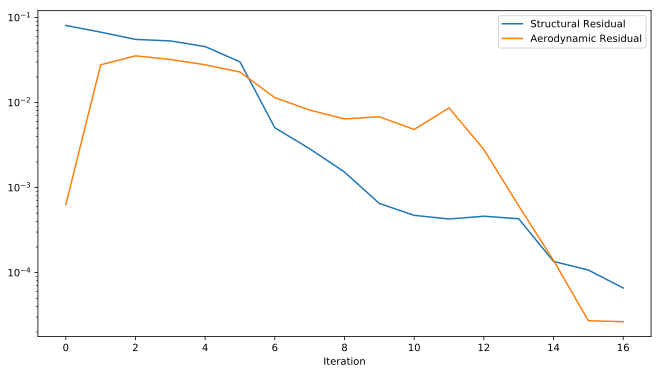

In [6]:
matplotlib.rcParams['figure.figsize'] = [11, 6]
# Plot current geometry
fig,ax=plt.subplots(1,1)
ax.plot(p.foils[0].X[0,:],.2*(bl[0].bl_fl.nodes.ue**2-1),'-',color='tab:orange')
vfp.plot_geometry(ax,p,bl)
# Plot pressure in same plot
ax.legend(['Final pressure','Initial Geometry','Deformed Geometry'])

fig.canvas.draw()
#ax.set_xlim(-.1,2)
# Plot Residuals with iterations
fig, ax = plt.subplots()
ax.semilogy(vres_s)
ax.semilogy(vres_a)
ax.legend(['Structural Residual','Aerodynamic Residual'])
ax.set_xlabel('Iteration');